# Modelo para estimar el valor de R0 con el uso de Redes Bayesianas 


In [1]:
import pandas as pd
import numpy as np
import ipywidgets


from matplotlib import pyplot as plt
from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

from scipy import stats as sps
from scipy.interpolate import interp1d
plt.style.use("fivethirtyeight")# for pretty graphs
from IPython.display import clear_output

##the world is filtered out
FILTERED_REGIONS = [
    'World']

%config InlineBackend.figure_format = 'retina'

In [2]:
# Column vector of k
k = np.arange(0, 70)[:, None]

# Different values of Lambda
lambdas = [10, 20, 30, 40]

# Evaluated the Probability Mass Function (remember: poisson is discrete)
y = sps.poisson.pmf(k, lambdas)

# Show the resulting shape
print(y.shape)

(70, 4)


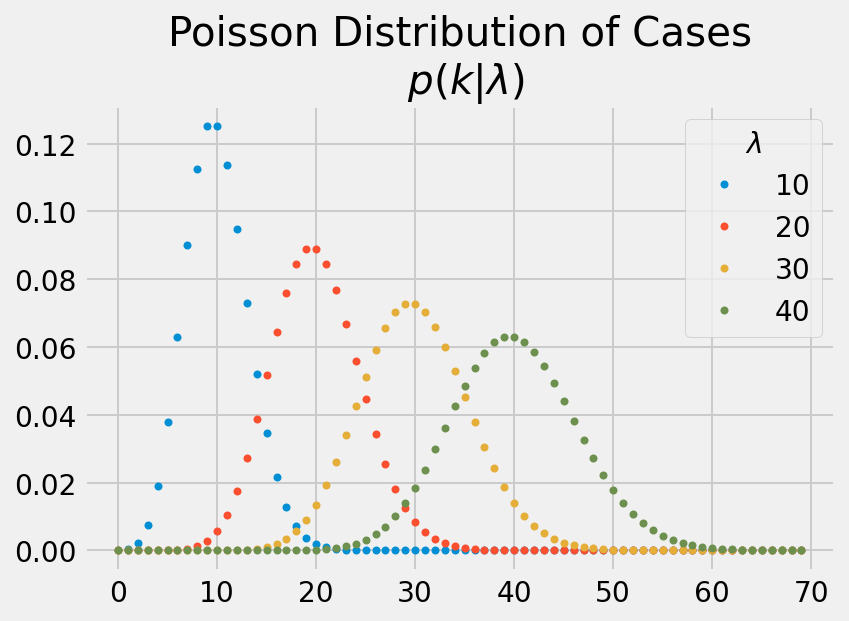

In [3]:
fig, ax = plt.subplots()

ax.set(title='Poisson Distribution of Cases\n $p(k|\lambda)$')

plt.plot(k, y,
         marker='o',
         markersize=3,
         lw=0)

plt.legend(title="$\lambda$", labels=lambdas);

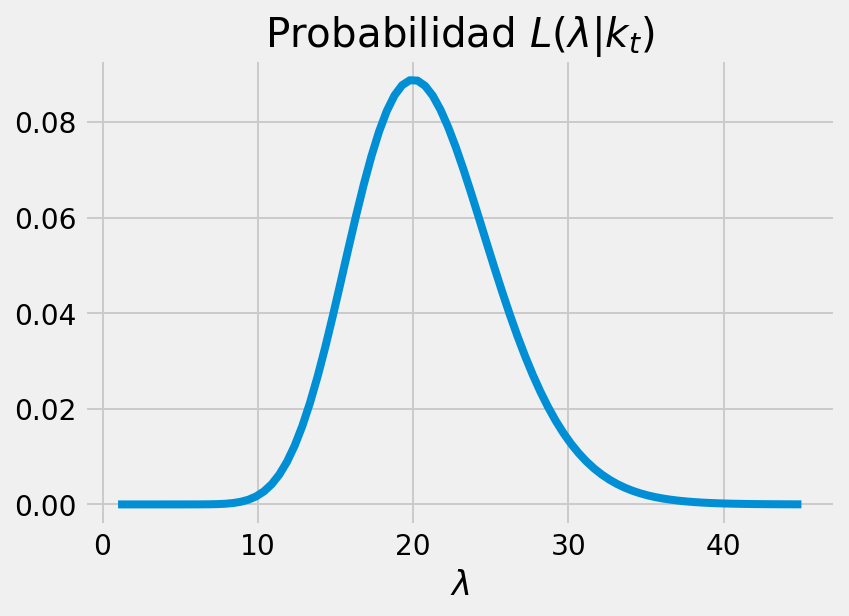

In [4]:
k = 20

lam = np.linspace(1, 45, 90)

likelihood = pd.Series(data=sps.poisson.pmf(k, lam),
                       index=pd.Index(lam, name='$\lambda$'),
                       name='lambda')

likelihood.plot(title=r'Probabilidad $L\left(\lambda|k_t\right)$');

# evaluando la función de probabilidad

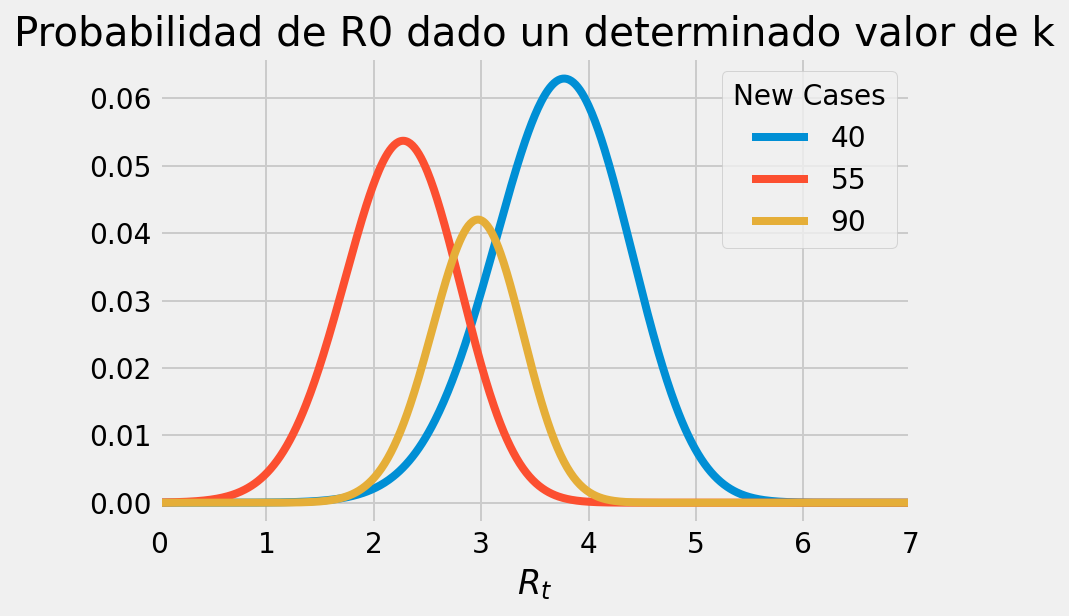

In [5]:
k = np.array([20, 40, 55, 90])

# We create an array for every possible value of Rt
R_T_MAX = 12
r_t_range = np.linspace(0, R_T_MAX, R_T_MAX*100+1)

# Gamma is 1/serial interval
# https://wwwnc.cdc.gov/eid/article/26/6/20-0357_article
GAMMA = 1/4

# Map Rt into lambda so we can substitute it into the equation below
# Note that we have N-1 lambdas because on the first day of an outbreak
# you do not know what to expect.
lam = k[:-1] * np.exp(GAMMA * (r_t_range[:, None] - 1))

# Evaluate the likelihood on each day and normalize sum of each day to 1.0
likelihood_r_t = sps.poisson.pmf(k[1:], lam)
likelihood_r_t / np.sum(likelihood_r_t, axis=0)

# Plot it
ax = pd.DataFrame(
    data = likelihood_r_t,
    index = r_t_range
).plot(
    title='Probabilidad de R0 dado un determinado valor de k',
    xlim=(0,7)
)

ax.legend(labels=k[1:], title='New Cases')
ax.set_xlabel('$R_t$');


### Calculando la función Bayesiana 


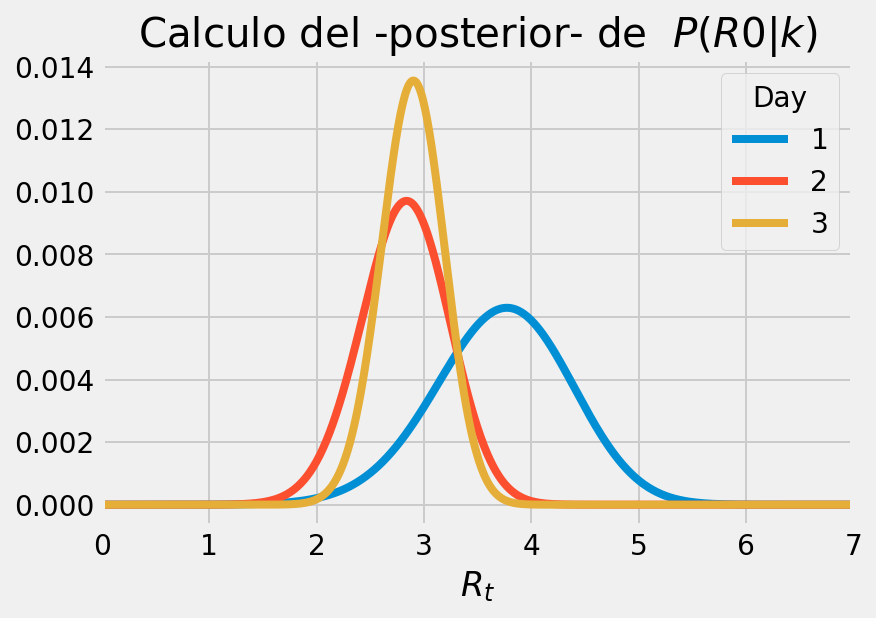

In [6]:
posteriors = likelihood_r_t.cumprod(axis=1)
posteriors = posteriors / np.sum(posteriors, axis=0)

columns = pd.Index(range(1, posteriors.shape[1]+1), name='Day')
posteriors = pd.DataFrame(
    data = posteriors,
    index = r_t_range,
    columns = columns)

ax = posteriors.plot(
    title='Calculo del -posterior- de  $P(R0|k)$',
    xlim=(0,7)
)
ax.legend(title='Day')
ax.set_xlabel('$R_t$');

In [7]:
most_likely_values = posteriors.idxmax(axis=0)

In [8]:
def highest_density_interval(pmf, p=.95):
    
    # If we pass a DataFrame, just call this recursively on the columns
    if(isinstance(pmf, pd.DataFrame)):
        pmf_list=[]
        for col in pmf:
            pmf_high=highest_density_interval(pmf[col])
            pmf_list.append(pmf_high)
        return pd.DataFrame(pmf_list,index=pmf.columns)
    
    cumsum = np.cumsum(pmf.values)
    
    best = None
    for i, value in enumerate(cumsum):
        for j, high_value in enumerate(cumsum[i+1:]):
            if (high_value-value > p) and (not best or j<best[1]-best[0]):
                best = (i, i+j+1)
                break
    try:        
        low = pmf.index[best[0]]
        high = pmf.index[best[1]]
    except:
        low = np.nan
        high = np.nan
    
    return pd.Series([low, high], index=['Low', 'High'])

hdi = highest_density_interval(posteriors, p=.95)

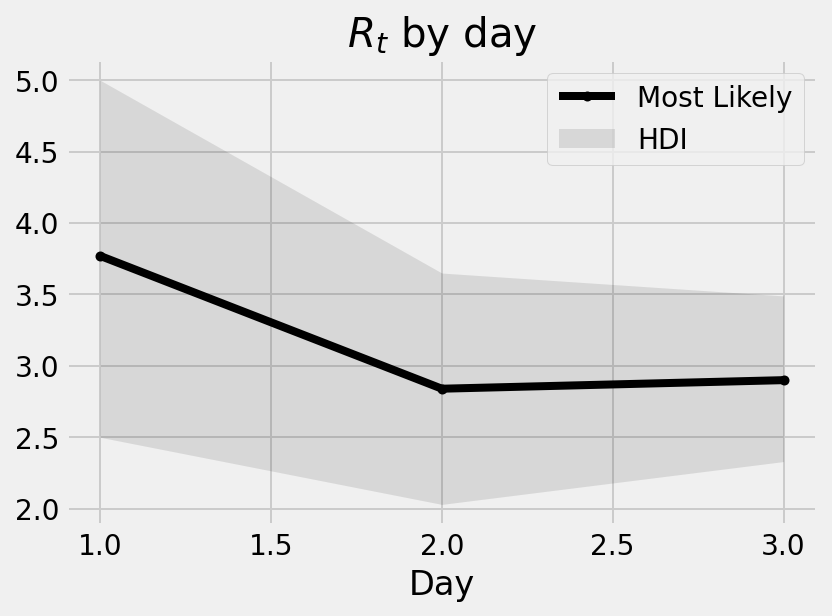

In [9]:
ax = most_likely_values.plot(marker='o',
                             label='Most Likely',
                             title=f'$R_t$ by day',
                             c='k',
                             markersize=4)

ax.fill_between(hdi.index,
                hdi['Low'],
                hdi['High'],
                color='k',
                alpha=.1,
                lw=0,
                label='HDI')

ax.legend();

# Aplicando los datods el modelo a casos de paises 

## vamos a leer los datosde un repositorio 

In [10]:
data = 'https://covid.ourworldindata.org/data/ecdc/full_data.csv'
countries = pd.read_csv(data,
                     usecols=[0,1,4],
                     index_col=['location', 'date'],
                     parse_dates=['date'],
                     squeeze=True).sort_index()

In [11]:
## the list of countries available
list(countries.reset_index()['location'].unique())

['Afghanistan',
 'Albania',
 'Algeria',
 'Andorra',
 'Angola',
 'Anguilla',
 'Antigua and Barbuda',
 'Argentina',
 'Armenia',
 'Aruba',
 'Australia',
 'Austria',
 'Azerbaijan',
 'Bahamas',
 'Bahrain',
 'Bangladesh',
 'Barbados',
 'Belarus',
 'Belgium',
 'Belize',
 'Benin',
 'Bermuda',
 'Bhutan',
 'Bolivia',
 'Bonaire Sint Eustatius and Saba',
 'Bosnia and Herzegovina',
 'Botswana',
 'Brazil',
 'British Virgin Islands',
 'Brunei',
 'Bulgaria',
 'Burkina Faso',
 'Burundi',
 'Cambodia',
 'Cameroon',
 'Canada',
 'Cape Verde',
 'Cayman Islands',
 'Central African Republic',
 'Chad',
 'Chile',
 'China',
 'Colombia',
 'Comoros',
 'Congo',
 'Costa Rica',
 "Cote d'Ivoire",
 'Croatia',
 'Cuba',
 'Curacao',
 'Cyprus',
 'Czech Republic',
 'Democratic Republic of Congo',
 'Denmark',
 'Djibouti',
 'Dominica',
 'Dominican Republic',
 'Ecuador',
 'Egypt',
 'El Salvador',
 'Equatorial Guinea',
 'Eritrea',
 'Estonia',
 'Ethiopia',
 'Faeroe Islands',
 'Falkland Islands',
 'Fiji',
 'Finland',
 'France',
 

There are around 210 countries in the dataset given excluding the data of total world data per day


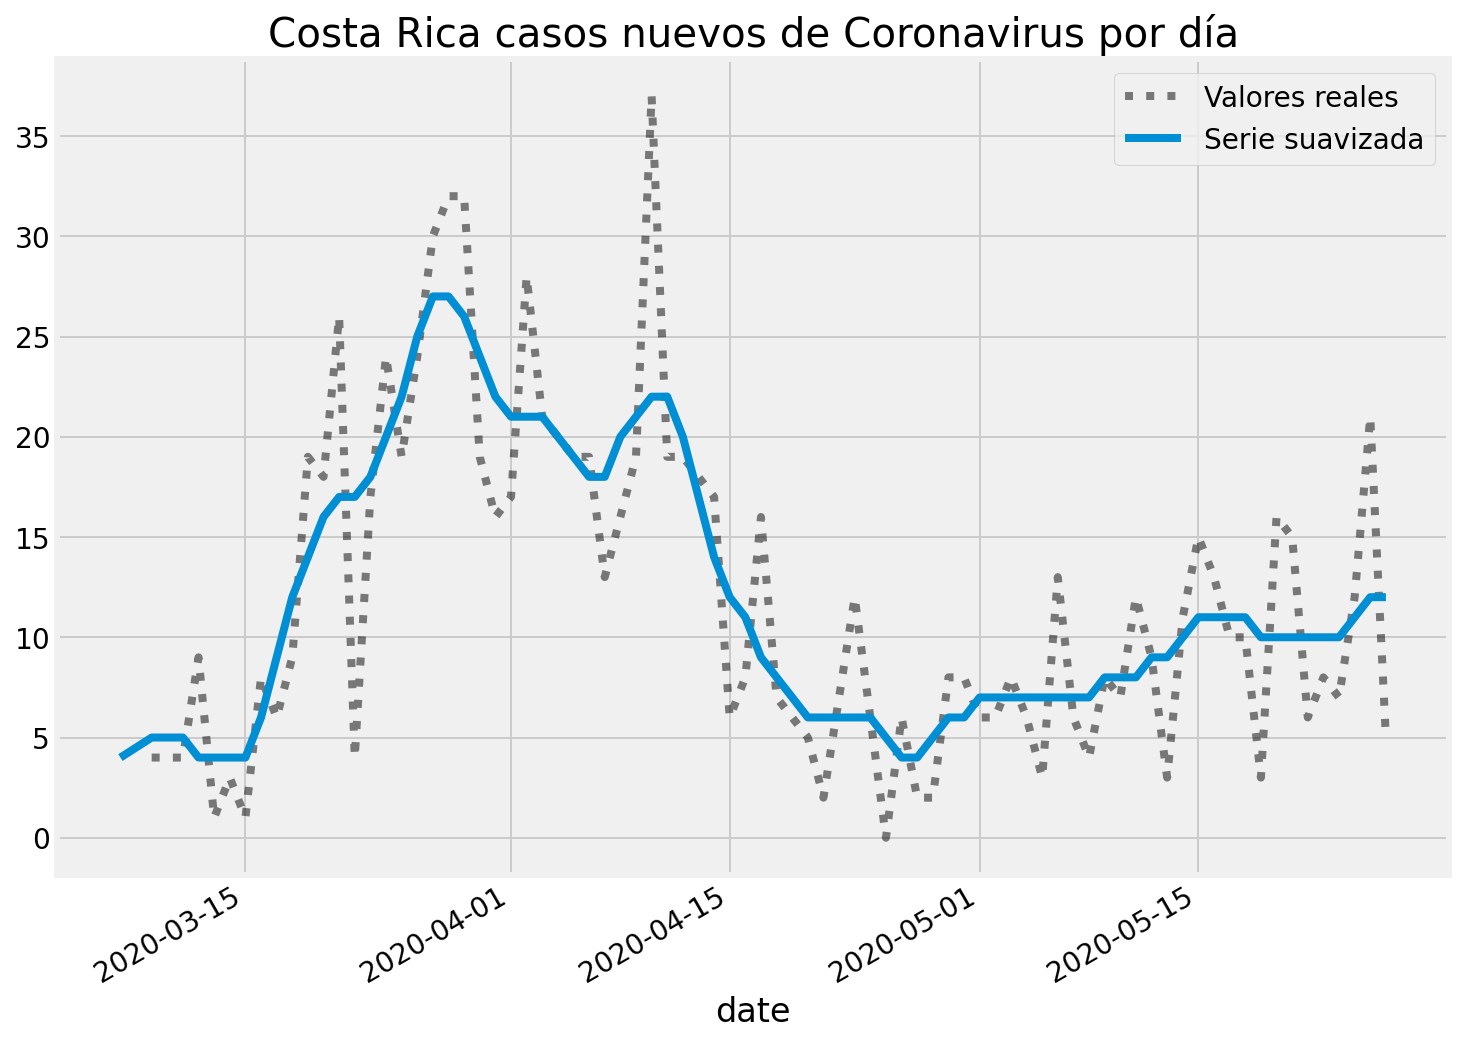

In [12]:
country_name = 'Costa Rica'

def prepare_cases(cases):
    new_cases = cases.diff()
    
    smoothed = new_cases.rolling(7,
        win_type='gaussian',
        min_periods=1,
        center=True).mean(std=2).round()
    zeros = smoothed.index[smoothed.eq(0)]
    if len(zeros) == 0:
        idx_start = 0
    else:
        last_zero = zeros.max()
        idx_start = smoothed.index.get_loc(last_zero) + 1
    smoothed = smoothed.iloc[idx_start:]
    original = new_cases.loc[smoothed.index]
    
    return original, smoothed

cases = countries.xs(country_name).rename(f"{country_name} cases")

original, smoothed = prepare_cases(cases)

original.plot(title=f"{country_name} casos nuevos de Coronavirus por día",
               c='k',
               linestyle=':',
               alpha=.5,
               label='Valores reales',
               legend=True,
             figsize=(800/72, 600/72))

ax = smoothed.plot(label='Serie suavizada',
                   legend=True)
ax.get_figure().set_facecolor('w')

### Utilizando el algoritmo

In [13]:
def get_posteriors(sr, window=7, min_periods=1):
    lam = sr[:-1].values * np.exp(GAMMA * (r_t_range[:, None] - 1))

    # Note: if you want to have a Uniform prior you can use the following line instead.
    # I chose the gamma distribution because of our prior knowledge of the likely value
    # of R_t.
    
    # prior0 = np.full(len(r_t_range), np.log(1/len(r_t_range)))
    prior0 = np.log(sps.gamma(a=3).pdf(r_t_range) + 1e-14)

    likelihoods = pd.DataFrame(
        # Short-hand way of concatenating the prior and likelihoods
        data = np.c_[prior0, sps.poisson.logpmf(sr[1:].values, lam)],
        index = r_t_range,
        columns = sr.index)

    # Perform a rolling sum of log likelihoods. This is the equivalent
    # of multiplying the original distributions. Exponentiate to move
    # out of log.
    posteriors = likelihoods.rolling(window,
                                     axis=1,
                                     min_periods=min_periods).sum()
    posteriors = np.exp(posteriors)

    # Normalize to 1.0
    posteriors = posteriors.div(posteriors.sum(axis=0), axis=1)
    
    return posteriors

posteriors = get_posteriors(smoothed)

### El resultado


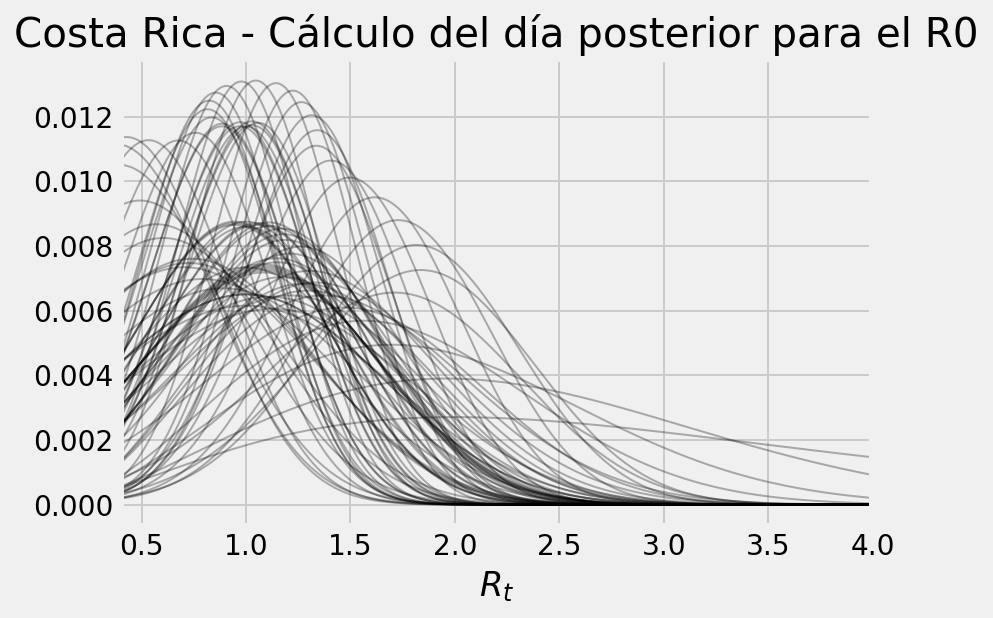

In [14]:
ax = posteriors.plot(title=f'{country_name} - Cálculo del día posterior para el R0',
           legend=False, 
           lw=1,
           c='k',
           alpha=.3,
           xlim=(0.4,4))

ax.set_xlabel('$R_t$');

### Graficando en el dominio de tiempo 

In [15]:
# Note that this takes a while to execute - it's not the most efficient algorithm
hdis = highest_density_interval(posteriors)

most_likely = posteriors.idxmax().rename('ML')

# Look into why you shift -1
result = pd.concat([most_likely, hdis], axis=1)

result.tail()

ML   Low  High
date                        
2020-05-23  0.94  0.09  1.76
2020-05-24  0.94  0.10  1.78
2020-05-25  1.00  0.15  1.87
2020-05-26  1.11  0.23  1.99
2020-05-27  1.11  0.24  1.98

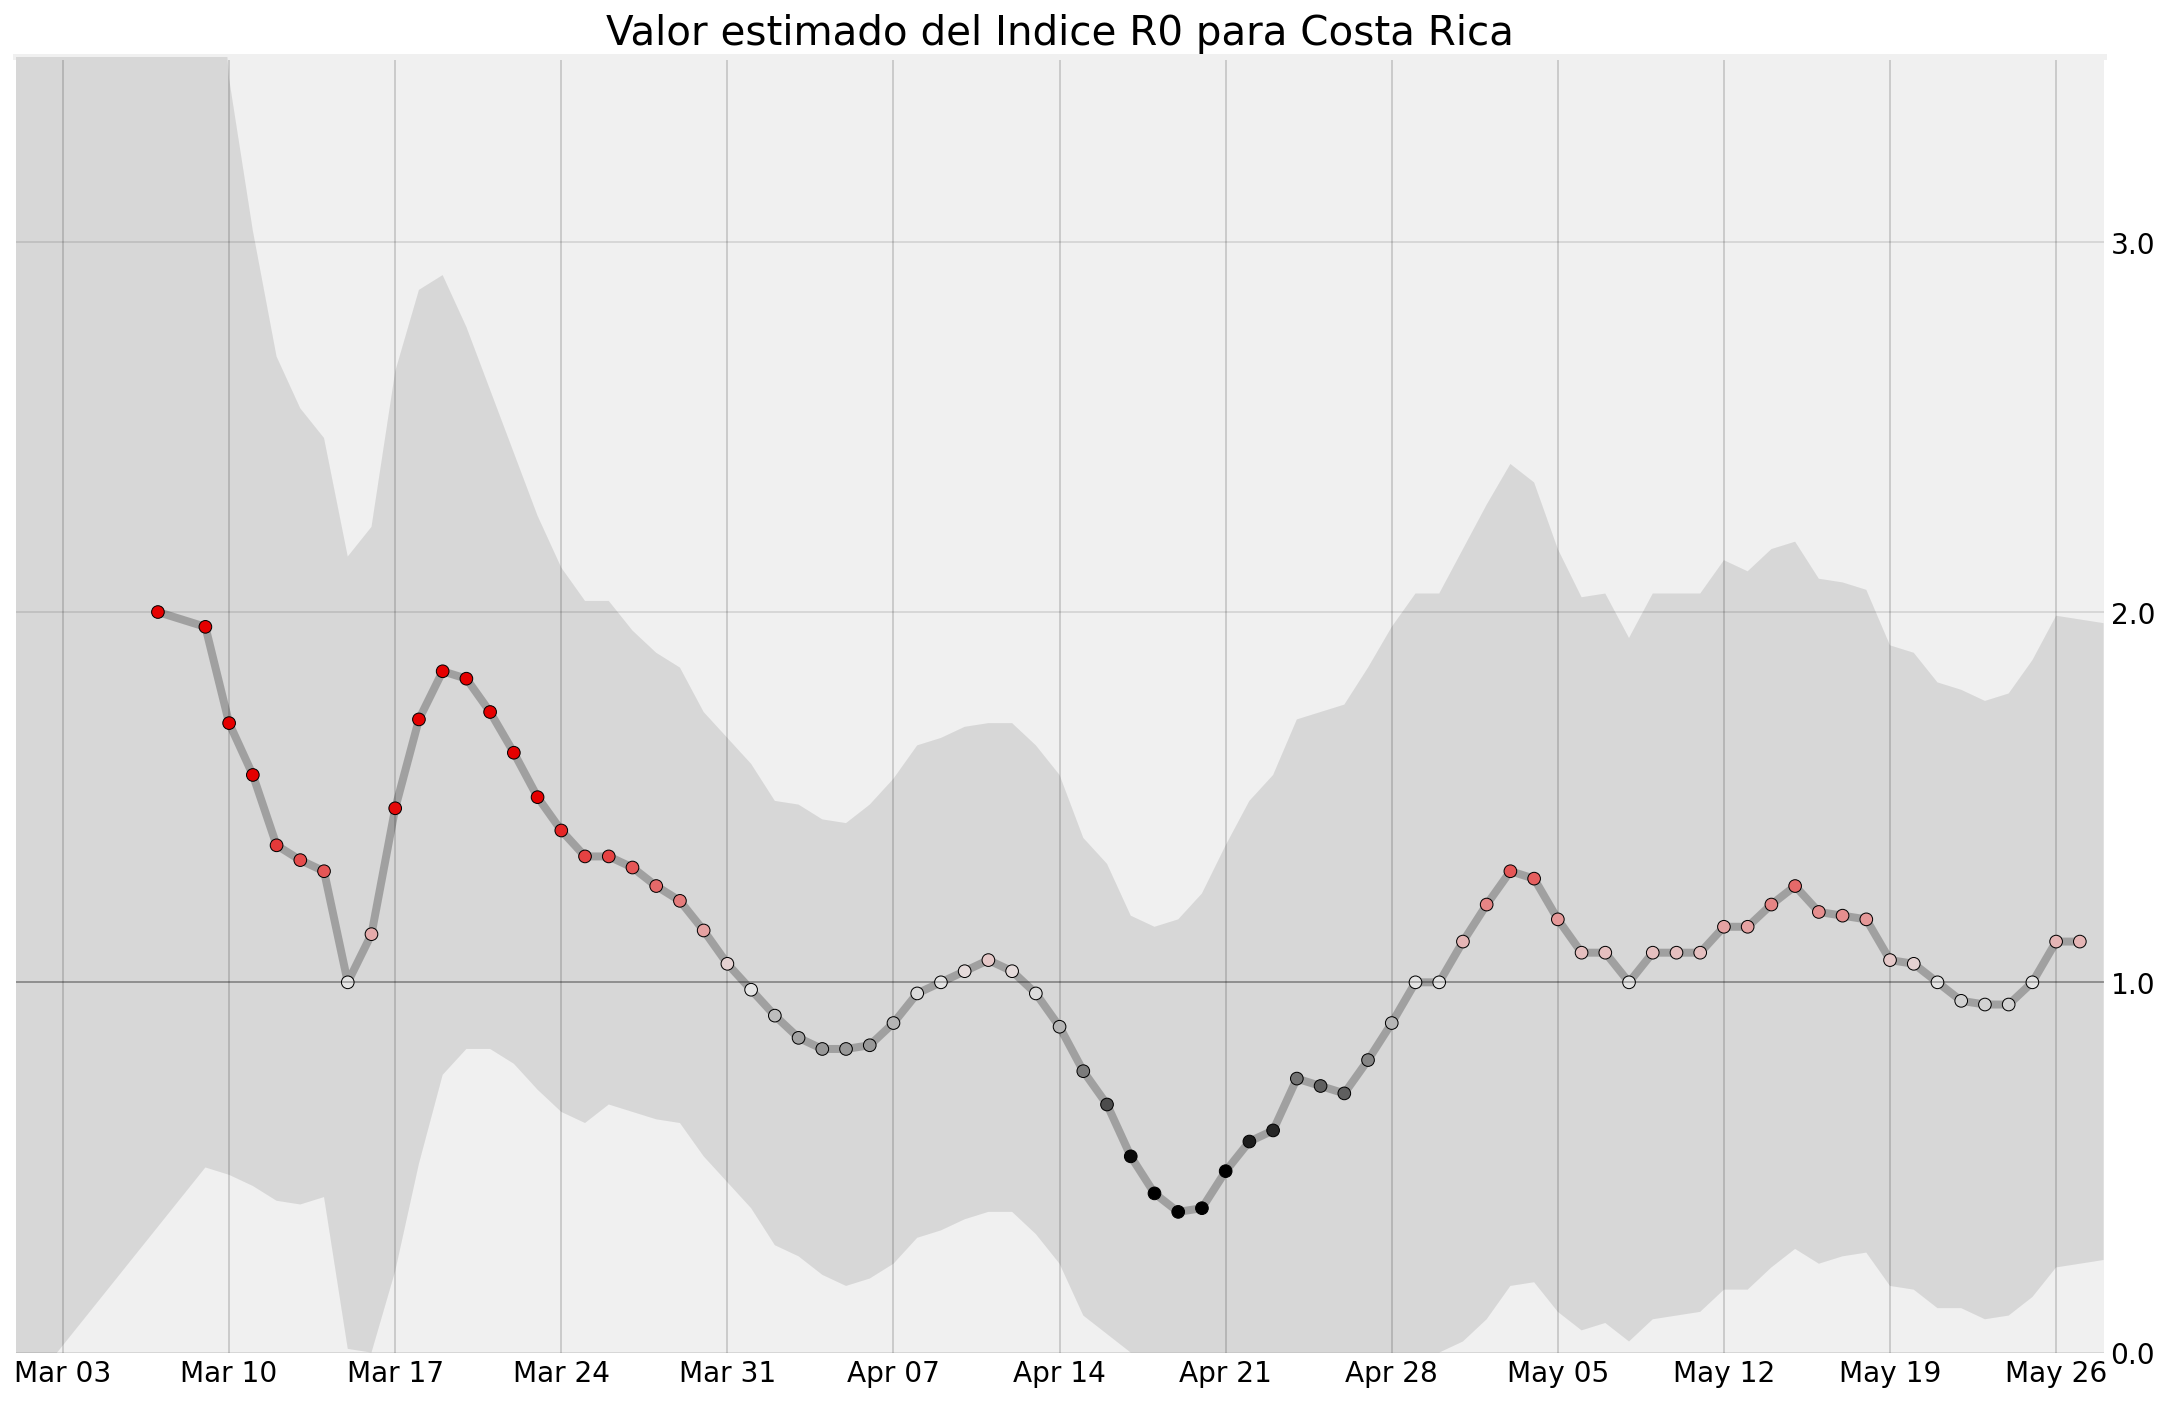

In [16]:
def plot_rt(result, ax, country_name):
    
    ax.set_title(f"{country_name}")
    
    # Colors
    ABOVE = [1,0,0]
    MIDDLE = [1,1,1]
    BELOW = [0,0,0]
    cmap = ListedColormap(np.r_[
        np.linspace(BELOW,MIDDLE,25),
        np.linspace(MIDDLE,ABOVE,25)
    ])
    color_mapped = lambda y: np.clip(y, .5, 1.5)-.5
    
    index = result['ML'].index.get_level_values('date')
    values = result['ML'].values
    
    # Plot dots and line
    ax.plot(index, values, c='k', zorder=1, alpha=.25)
    ax.scatter(index,
               values,
               s=40,
               lw=.5,
               c=cmap(color_mapped(values)),
               edgecolors='k', zorder=2)
    
    # Aesthetically, extrapolate credible interval by 1 day either side
    lowfn = interp1d(date2num(index),
                     result['Low'].values,
                     bounds_error=False,
                     fill_value='extrapolate')
    
    highfn = interp1d(date2num(index),
                      result['High'].values,
                      bounds_error=False,
                      fill_value='extrapolate')
    
    extended = pd.date_range(start=pd.Timestamp('2020-03-01'),
                             end=index[-1]+pd.Timedelta(days=1))
    
    ax.fill_between(extended,
                    lowfn(date2num(extended)),
                    highfn(date2num(extended)),
                    color='k',
                    alpha=.1,
                    lw=0,
                    zorder=3)

    ax.axhline(1.0, c='k', lw=1, label='$R_t=1.0$', alpha=.25);
    
    # Formatting
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    ax.yaxis.tick_right()
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.margins(0)
    ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)
    ax.margins(0)
    ax.set_ylim(0.0,4)
    ax.set_xlim(pd.Timestamp('2020-03-01'), result.index.get_level_values('date')[-1]+pd.Timedelta(days=1))
    fig.set_facecolor('w')

    
fig, ax = plt.subplots(figsize=(1200/72,800/72))

plot_rt(result, ax, country_name)
ax.set_title(f'Valor estimado del Indice R0 para {country_name}')
ax.set_ylim(0,3.5)
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

### Utilizando el proceso para varios paises , anote entre comillas los paises que desea comparar

In [17]:
## give a list of countries
list_countries=['United States','Spain','Costa Rica', 'Brazil', 'Italy', 'United Kingdom']#list(countries.reset_index()['location'].unique())

results = {}

countries_to_process = countries.loc[~countries.index.get_level_values('location').isin(FILTERED_REGIONS)]
countries_to_process=countries_to_process.reset_index()
countries_to_process=countries_to_process[countries_to_process['location'].isin(list_countries)]
countries_to_process=countries_to_process.set_index(['location','date'])
countries_to_process=countries_to_process.squeeze()

for country_name, cases in countries_to_process.groupby(level='location'):
    clear_output(wait=True)
    print(f'Processing {country_name}')
    new, smoothed = prepare_cases(cases)
    print('\tGetting Posteriors')
    try:
        posteriors = get_posteriors(smoothed)
    except:
        display(cases)
    print('\tGetting HDIs')
    hdis = highest_density_interval(posteriors)
    print('\tGetting most likely values')
    most_likely = posteriors.idxmax().rename('ML')
    result = pd.concat([most_likely, hdis], axis=1)
    results[country_name] = result.reset_index().drop(['location'],axis=1)
    
clear_output(wait=True)
print('Done.')

Done.


### Graficando la lista de paises 

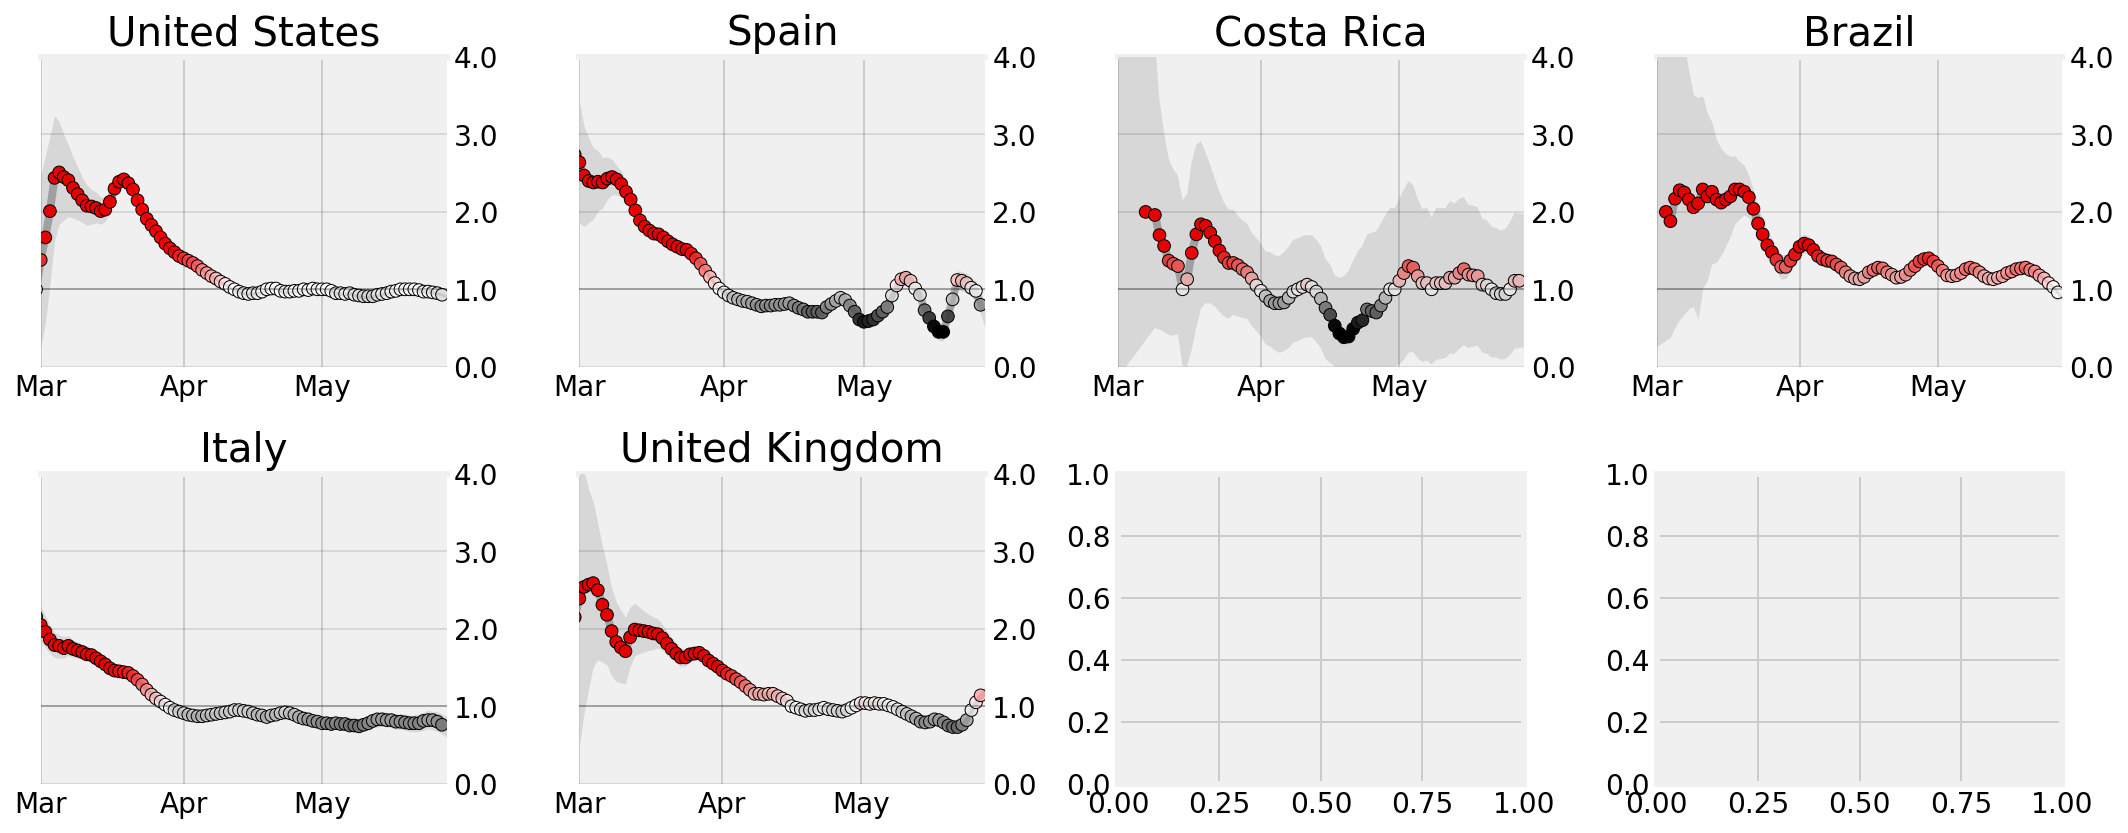

In [18]:
if len(list_countries)<4:
    ncols = len(list_countries)
else:
    ncols = 4
nrows = int(np.ceil(len(list_countries) / ncols))

# fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows*3))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows*3))
our_list={k: results[k]  for k in list_countries if k!='World'}
for i, (country_name, result) in enumerate(our_list.items()):
    result=result.set_index('date')
    if len(list_countries)==1:
        plot_rt(result, axes, country_name)
    else:
        plot_rt(result, axes.flat[i], country_name)

fig.tight_layout()
fig.set_facecolor('w')

### Modelo donde se obtienen las reglas para desconfinar paises ( de la lista seleccionada atras) 

In [19]:
overall = None

for country_name, result in results.items():
    r = result.copy()
    r.index = pd.MultiIndex.from_product([[country_name], result.index])
    if overall is None:
        overall = r
    else:
        overall = pd.concat([overall, r])

overall.sort_index(inplace=True)###  Modelo de decision para desconfinar o no entre los paises seleccionados atrás

In [20]:
FULL_COLOR = [.7,.7,.7]
ERROR_BAR_COLOR = [.3,.3,.3]
filtered = overall.index.get_level_values(0).isin(FILTERED_REGIONS)
mr = overall.loc[~filtered].groupby(level=0)[['ML', 'High', 'Low']].last()


In [21]:
def plot_standings(mr, figsize=None, title='Most Recent $R_t$ by State'):
    if not figsize:
        figsize = ((15.9/50)*len(mr)+.1,2.5)
        
    fig, ax = plt.subplots(figsize=figsize)

    ax.set_title(title)
    err = mr[['Low', 'High']].sub(mr['ML'], axis=0).abs()
    bars = ax.bar(mr.index,
                  mr['ML'],
                  width=.825,
                  color=FULL_COLOR,
                  ecolor=ERROR_BAR_COLOR,
                  capsize=2,
                  error_kw={'alpha':.5, 'lw':1},
                  yerr=err.values.T)



    labels = mr.index.to_series()
    ax.set_xticklabels(labels, rotation=90, fontsize=11)
    ax.margins(0)
    ax.set_ylim(0,2.)
    ax.axhline(1.0, linestyle=':', color='k', lw=1)

    fig.set_facecolor('w')
    return fig, ax


## Esta es la lista de paises completa ordenados por el valor actual de R0 sin importar la IMD 

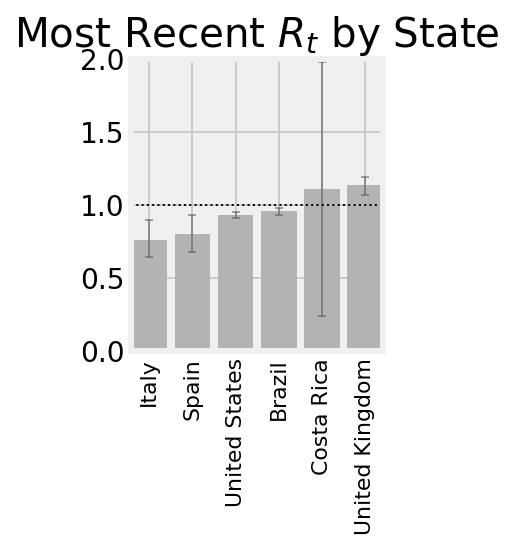

In [22]:
mr.sort_values('ML', inplace=True)
plot_standings(mr);

## Esta es la lista de los paises con los valores mas altos de R0
costa rica sale mas alto porque el IMD es altisimo 

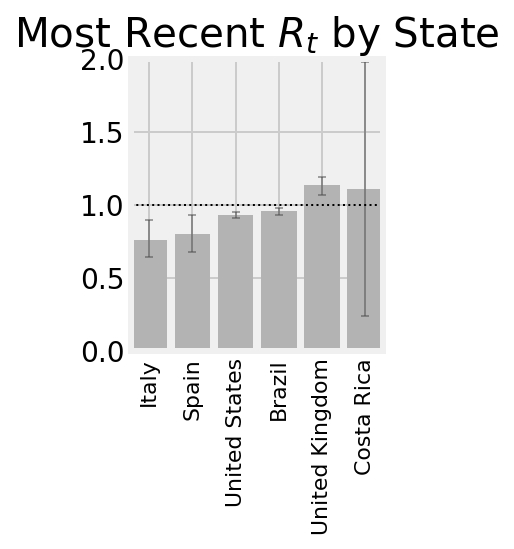

In [23]:
mr.sort_values('High', inplace=True)
plot_standings(mr);

## Esta es la lista de paises de la lista que se pueden considerar BAJO CONTROL 

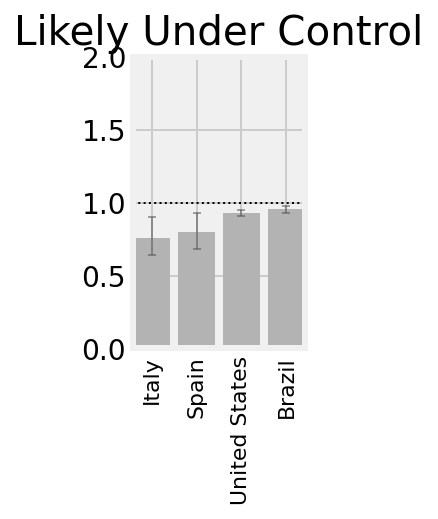

In [24]:
show = mr[mr.High.le(1.1)].sort_values('ML')
fig, ax = plot_standings(show, title='Likely Under Control');

### Esta es la lista de paises de la lista que se pueden considerar BAJO CONTROL

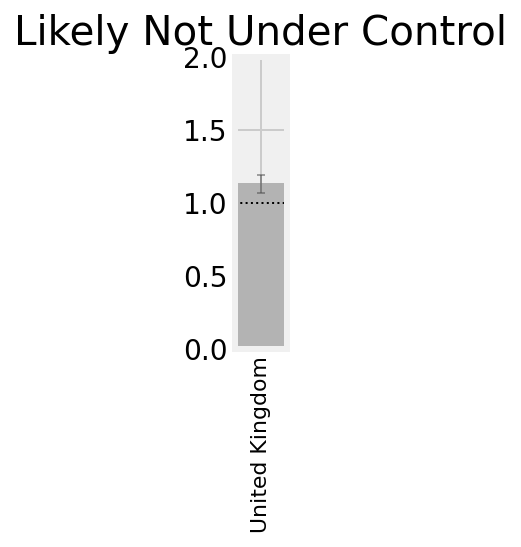

In [25]:
show = mr[mr.Low.ge(1.05)].sort_values('Low')
fig, ax = plot_standings(show, title='Likely Not Under Control');


### Predición y graficación 

In [28]:
from fbprophet import Prophet
from fbprophet.plot import plot_plotly
import plotly.offline as py
from scipy.stats import boxcox
from scipy.special import inv_boxcox
py.init_notebook_mode()
%matplotlib inline

In [29]:
country_name='Costa Rica'


In [30]:
data = 'https://covid.ourworldindata.org/data/ecdc/full_data.csv'
countries_full_data = pd.read_csv(data,
                     parse_dates=['date'],
                     squeeze=True).sort_index()
needed_dat=countries_full_data[countries_full_data['location']==country_name]

In [31]:
final_dataset=pd.merge(needed_dat,results[country_name],on='date',how='outer').drop(['Low','High'],axis=1)
final_dataset=final_dataset.rename(columns={'ML':'R0'})

In [32]:
import math
def prediction_part(final_dataset,feature):
    train_dataset= pd.DataFrame()

    case_dataset=final_dataset
    train_dataset['ds'] = pd.to_datetime(case_dataset["date"])
    # Apply Box-Cox Transform to value column and assign to new column y
    train_dataset['y'] = case_dataset[feature]
    # train_dataset['y']=final_dataset["total_cases"]
    train_dataset=train_dataset[~train_dataset.isin([np.nan, np.inf, -np.inf]).any(1)]
    prophet_basic = Prophet(yearly_seasonality=False, weekly_seasonality=False, daily_seasonality=False)
    prophet_basic.fit(train_dataset)

    future= prophet_basic.make_future_dataframe(periods=30)
    forecast = prophet_basic.predict(future)

    forecast=forecast.set_index('ds')
    train_dataset.set_index('ds',inplace=True)

    train_dataset.index = pd.to_datetime(train_dataset.index) #make sure our index as a datetime object
    connect_date = train_dataset.index[-1] #select the first to last date

    mask = (forecast.index > connect_date)
    predict_df = forecast.loc[mask]
    viz_df = train_dataset.join(predict_df[['yhat', 'yhat_lower','yhat_upper']], how = 'outer')

    fig, ax1 = plt.subplots(figsize=(12,8))

    ax1.plot(viz_df.y)
    ax1.plot(viz_df.yhat, color='black', linestyle=':')
    ax1.fill_between(viz_df.index,viz_df['yhat_upper'], viz_df['yhat_lower'], alpha=0.5, color='darkgray')
    for i,j in enumerate(zip(viz_df.index,viz_df.y)):
        if (i%10==0)&(not math.isnan(j[1])):
            if feature=='R0':
                ax1.annotate(str(round(j[1],3)),xy=(j[0],j[1]))
            else:
                ax1.annotate(str(int(j[1])),xy=(j[0],j[1]))

    for i,j in enumerate(zip(viz_df.index,viz_df.yhat)):
        if (i%10==0)&(not math.isnan(j[1])):
            if feature=='R0':
                ax1.annotate(str(round(j[1],3)),xy=(j[0],j[1]))
            else:
                ax1.annotate(str(int(j[1])),xy=(j[0],j[1]))
    ax1.set_title('Cifras actuales y estimadas de '+feature+ ' en '+country_name)
    ax1.set_ylabel(feature)
    ax1.set_xlabel('Fechas')

    ax1.legend(['Valores actuales','Predicción']) #get the legend
    plt.show()
    return viz_df

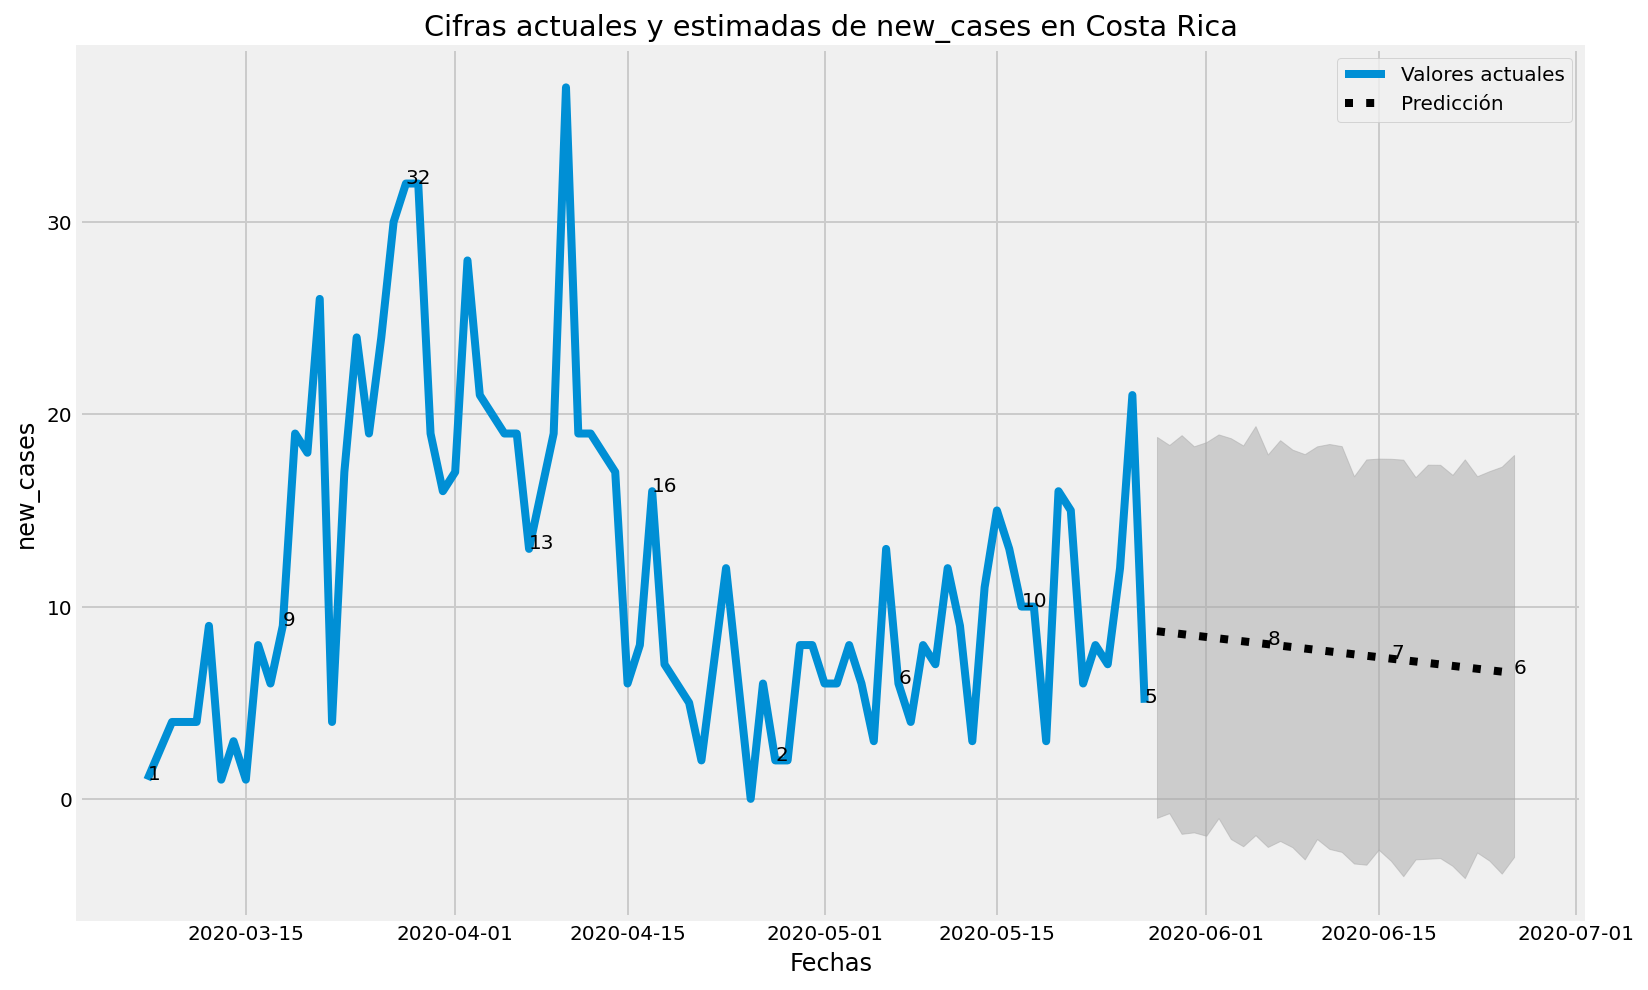

In [33]:
out1=prediction_part(final_dataset,'new_cases')

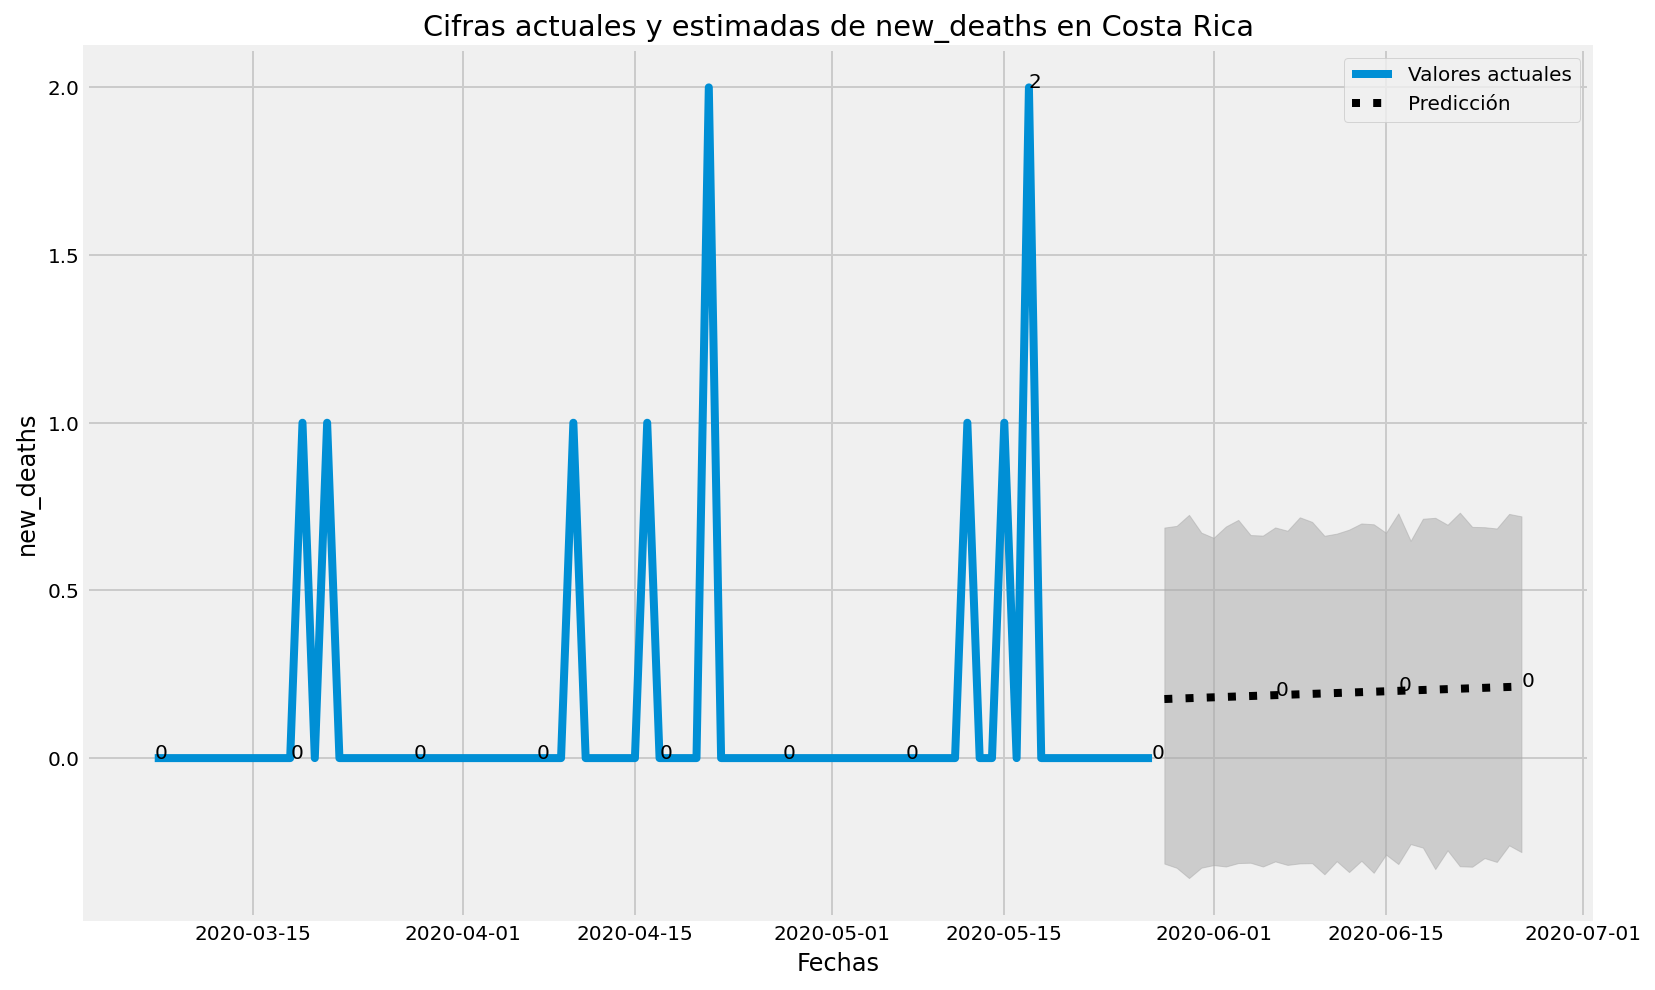

In [34]:
out2=prediction_part(final_dataset,'new_deaths')

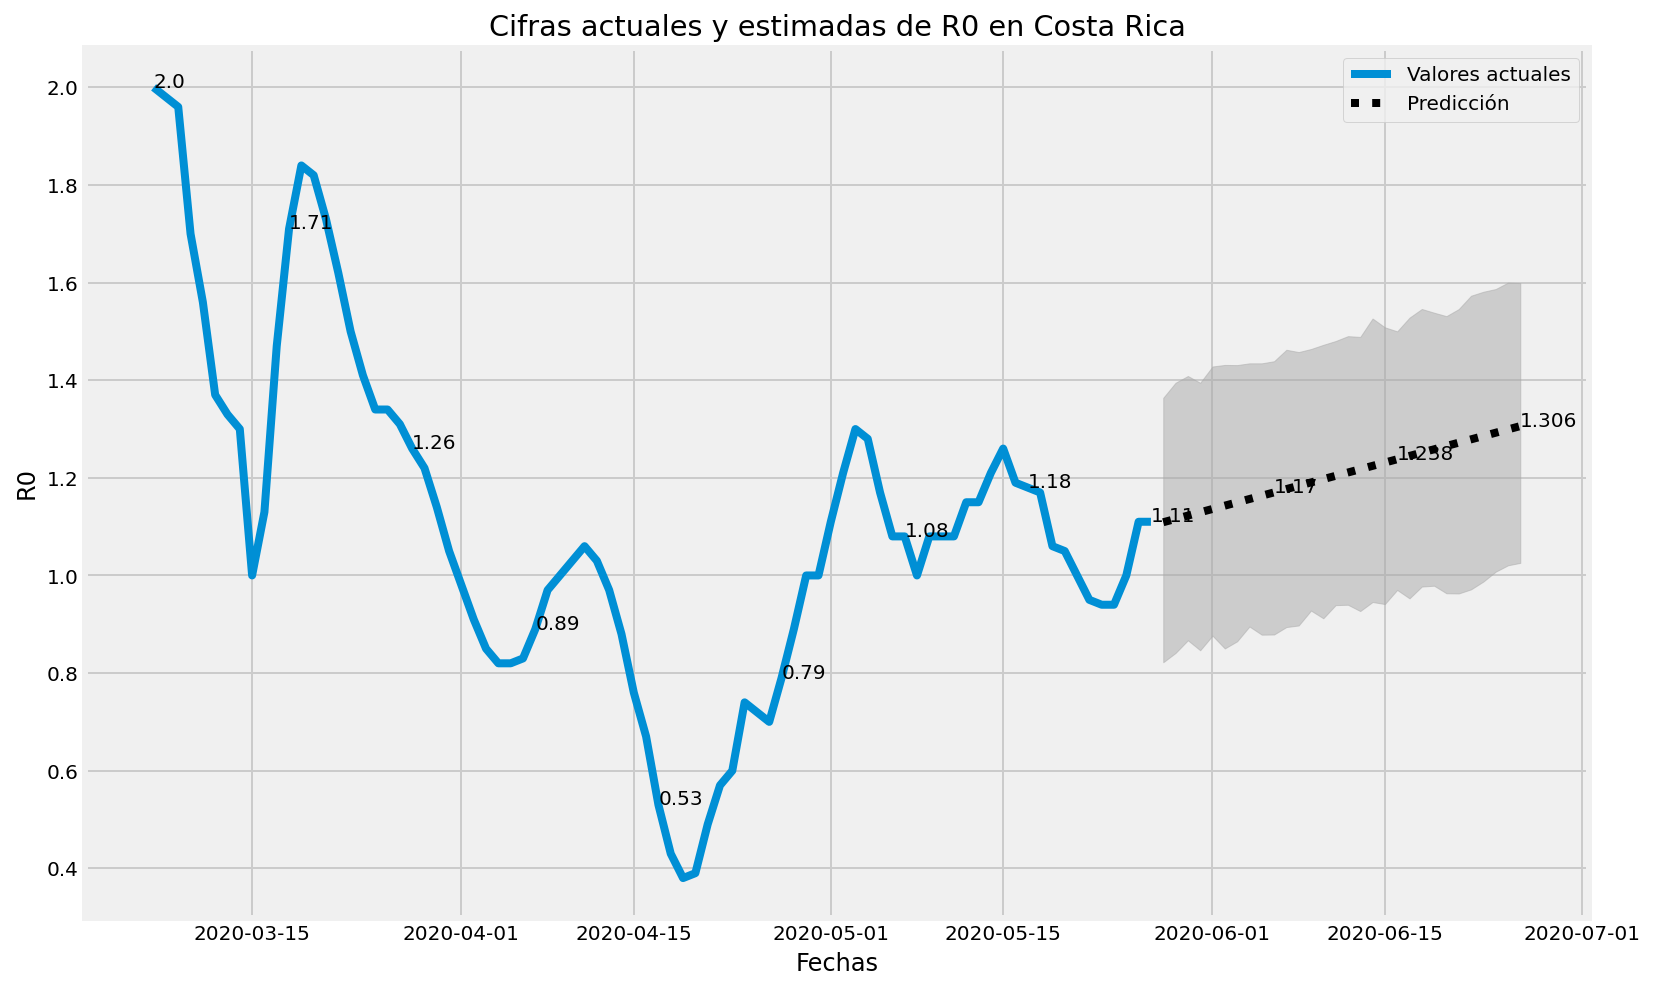

In [35]:
out3=prediction_part(final_dataset,'R0')

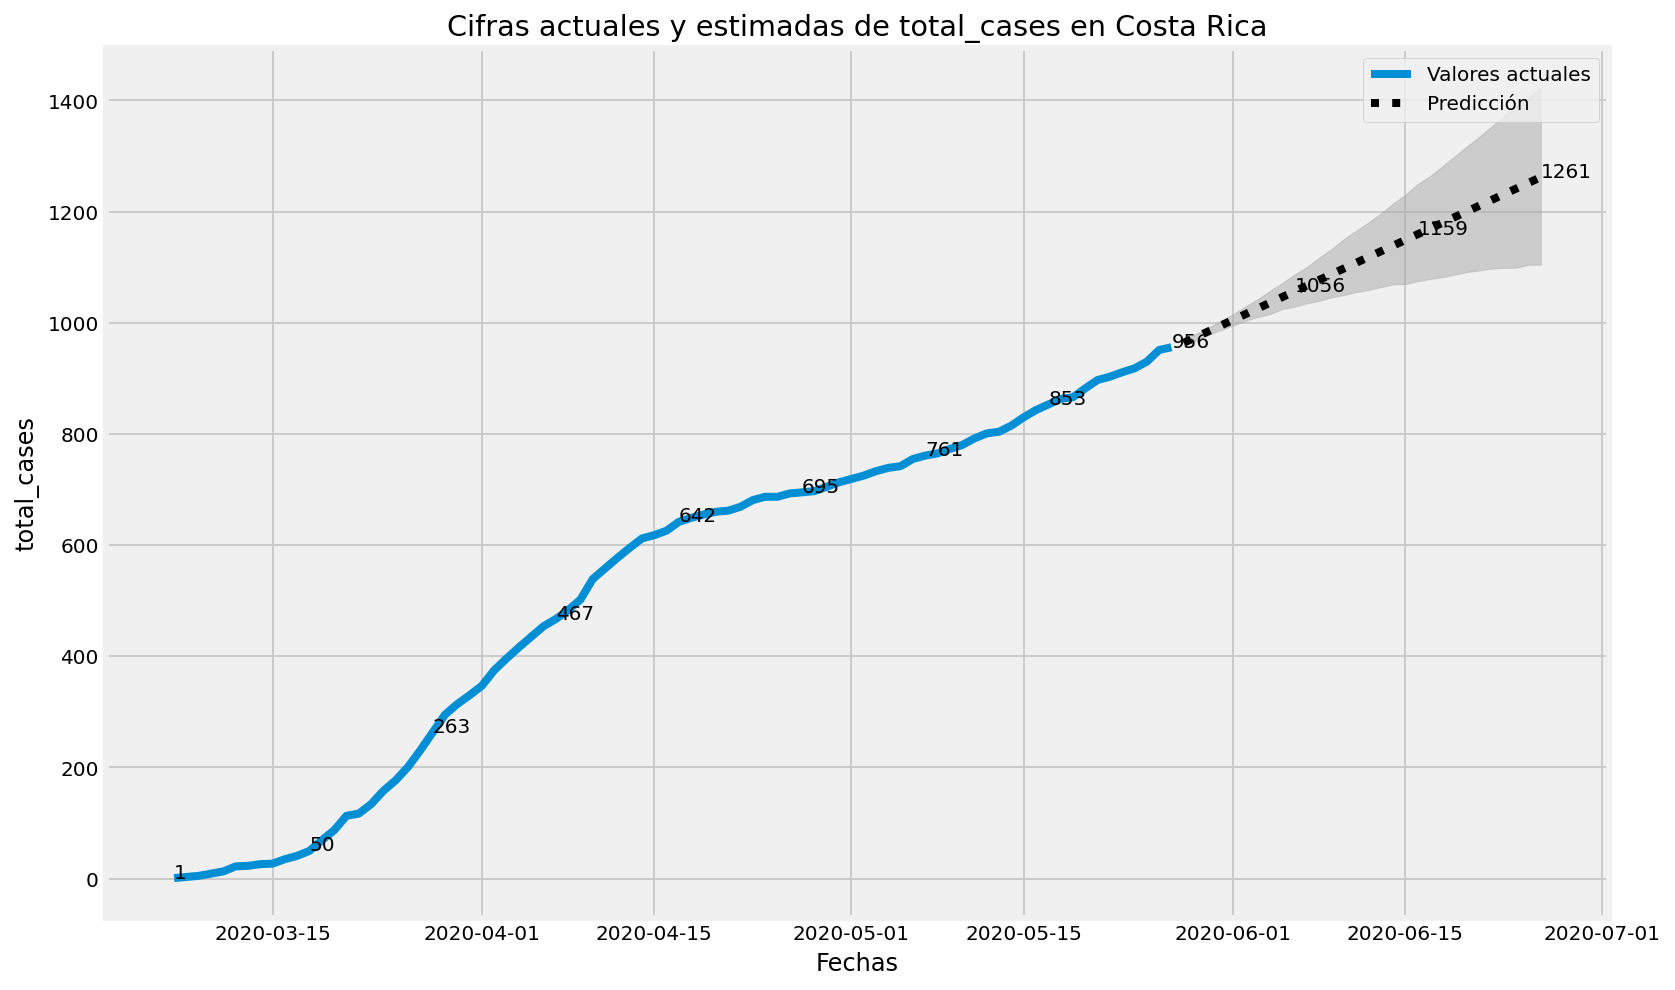

In [36]:
out4=prediction_part(final_dataset,'total_cases')

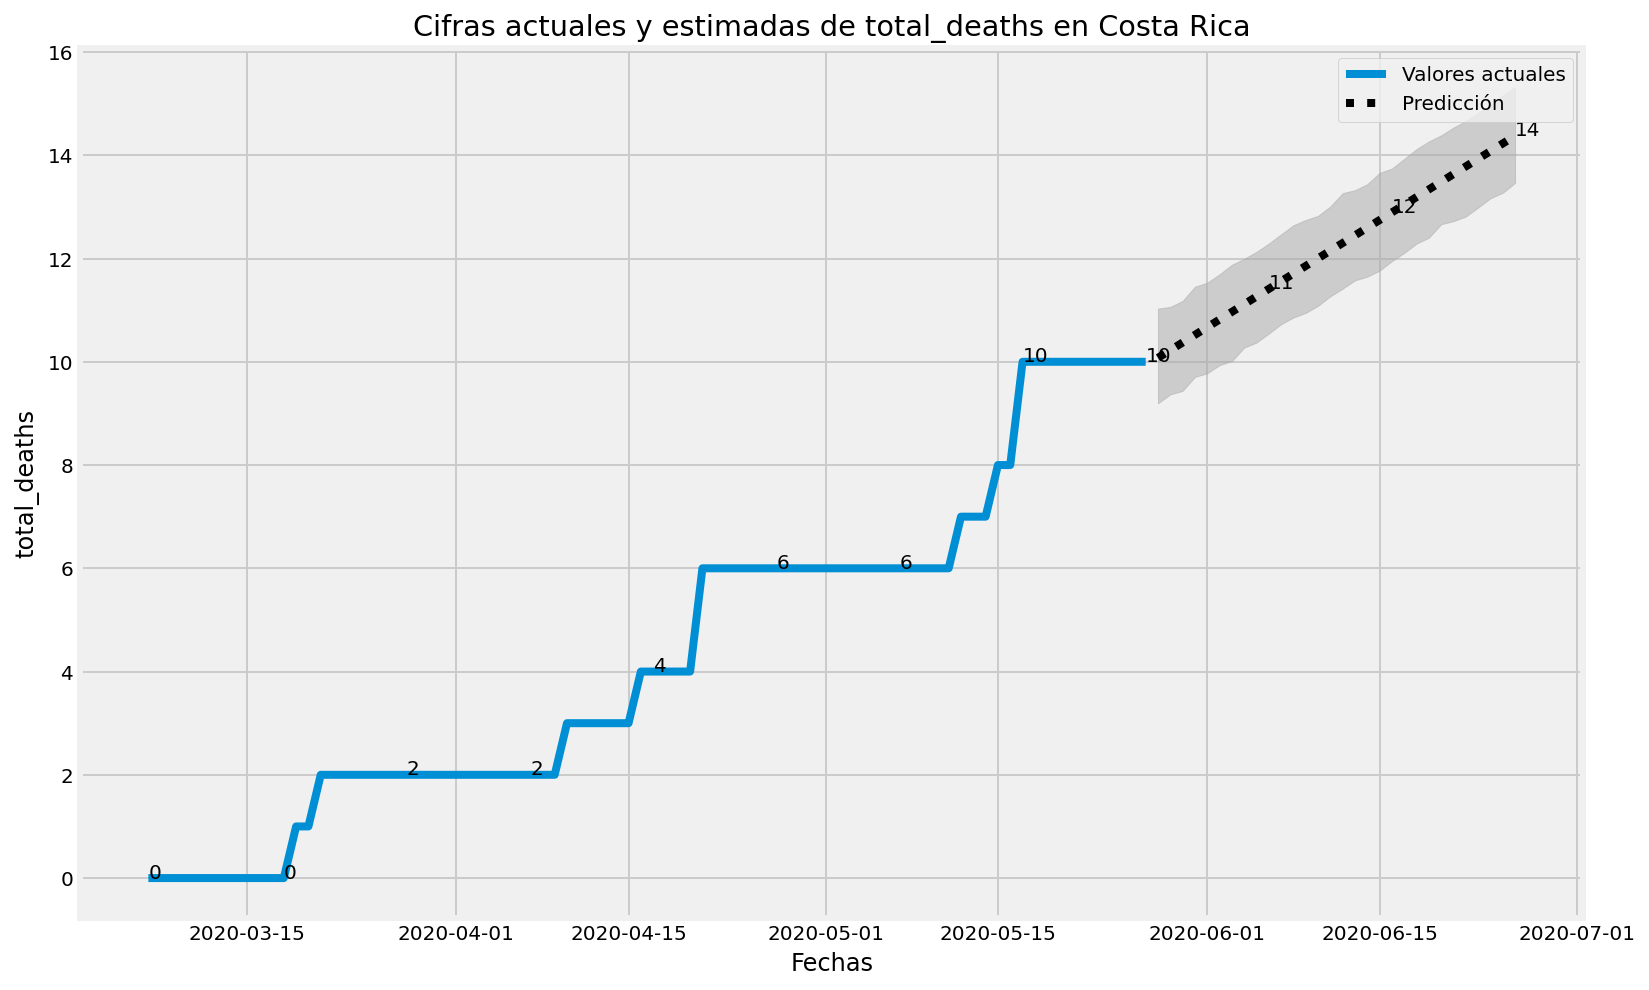

In [37]:
out5=prediction_part(final_dataset,'total_deaths')

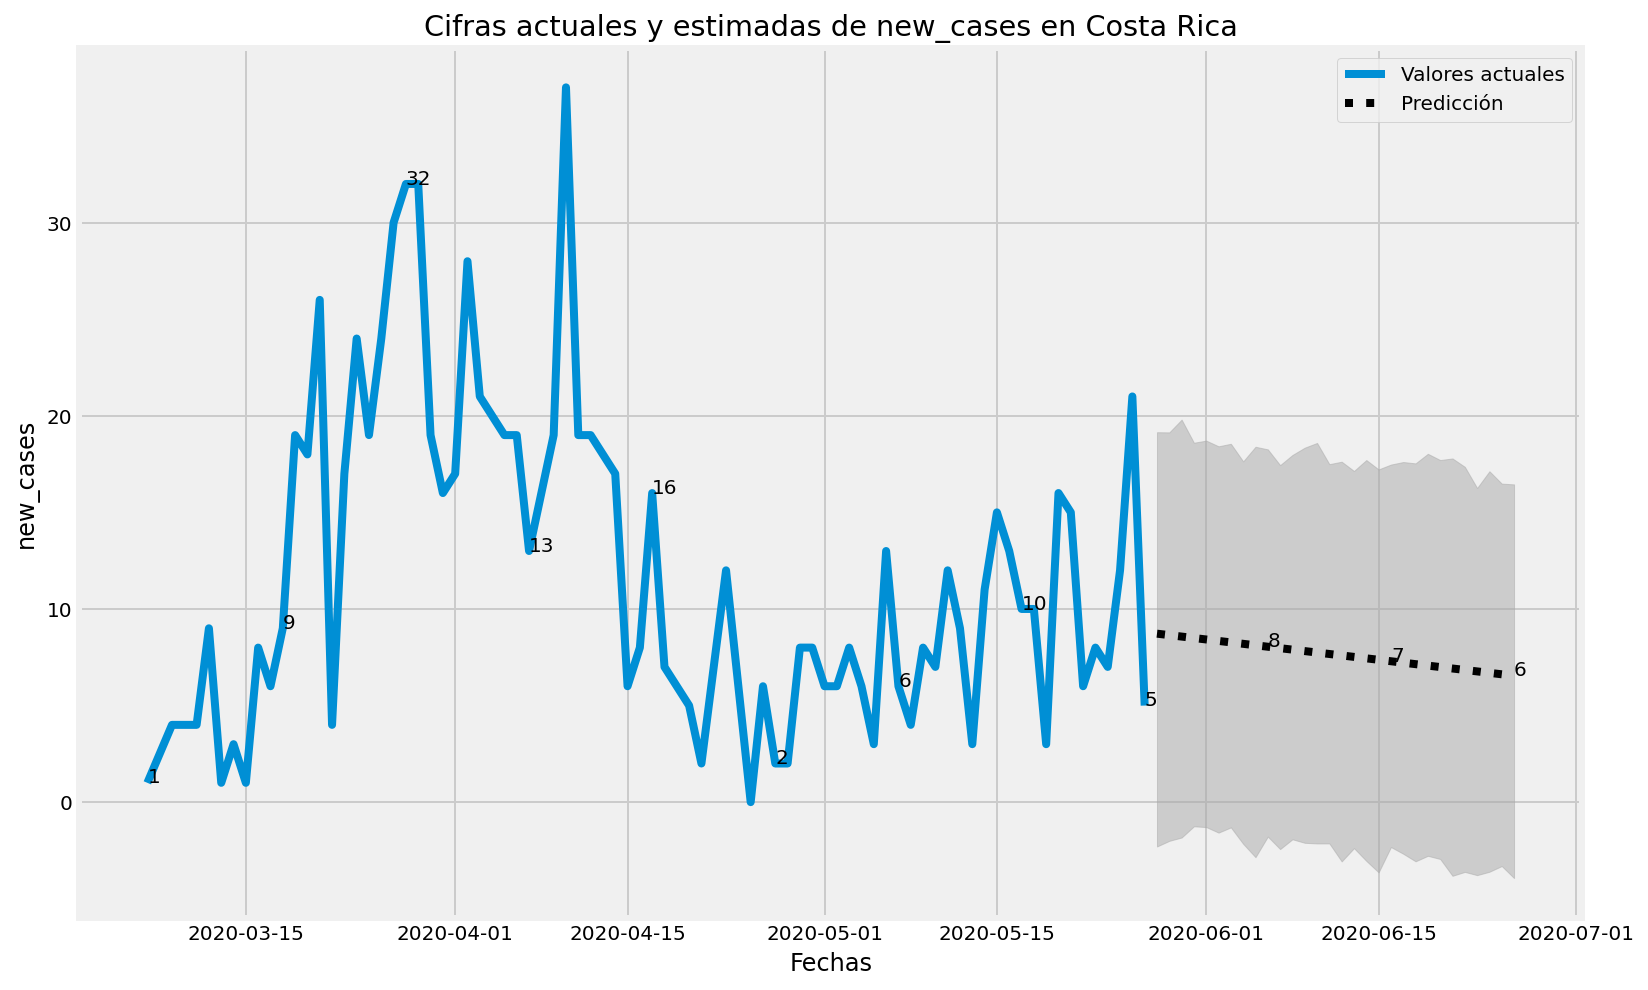

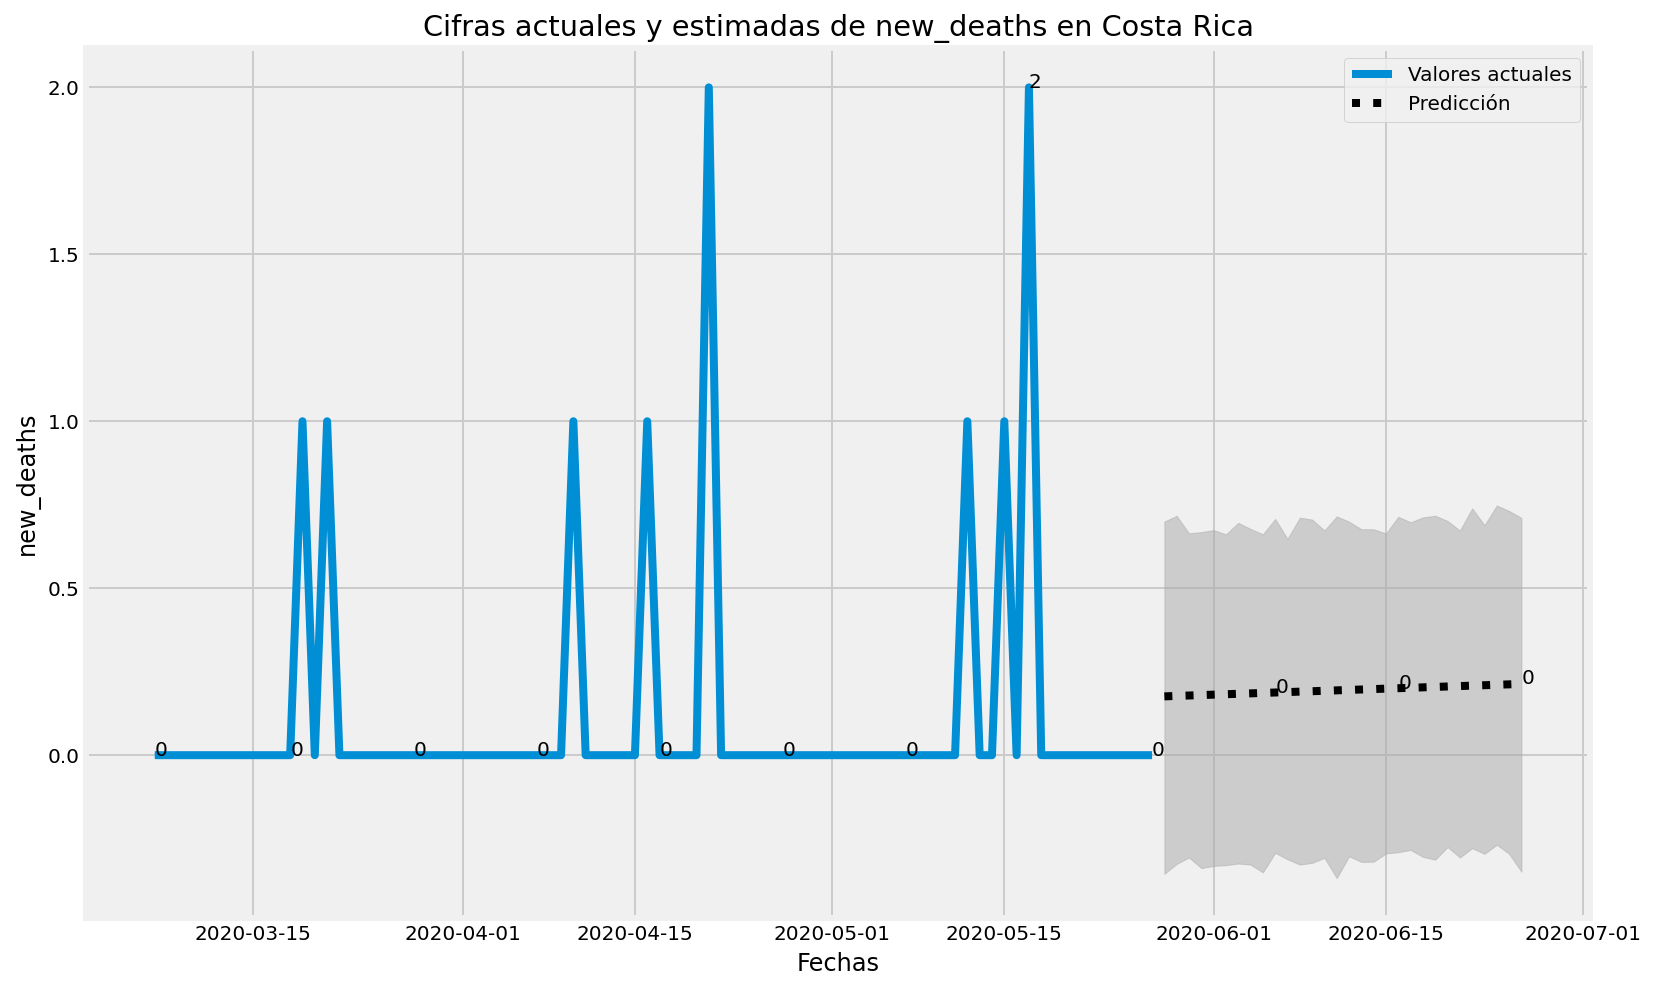

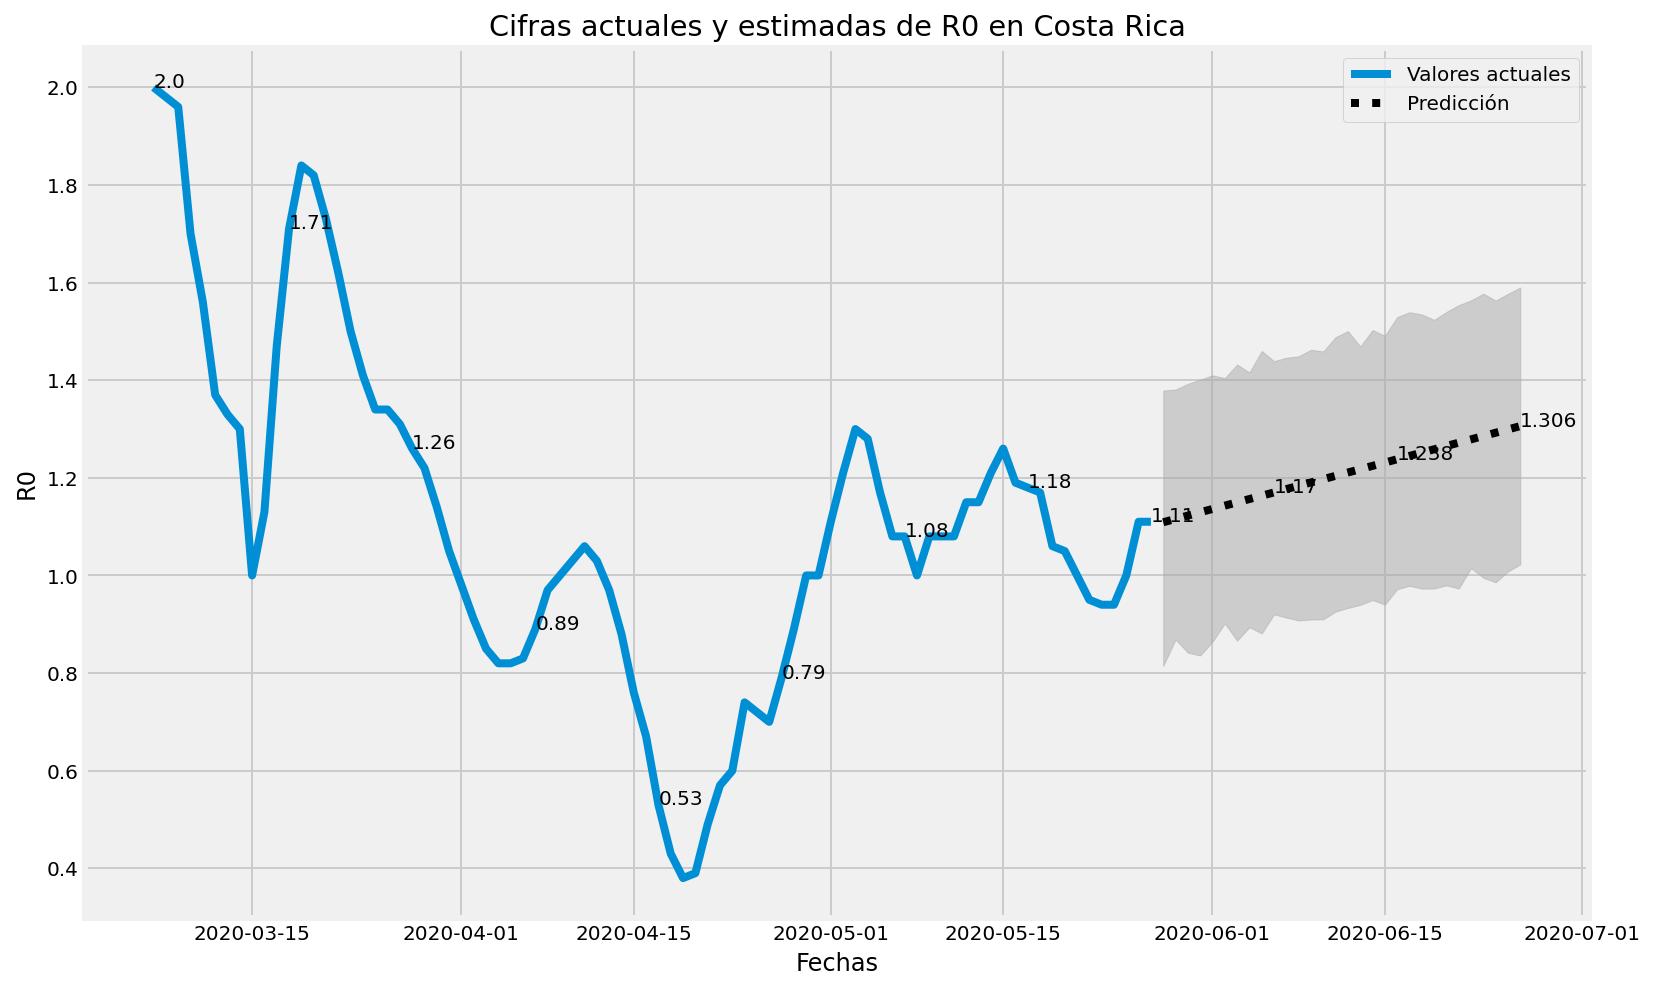

In [38]:
outfull=pd.DataFrame()
for feat in ['new_cases','new_deaths','R0']:
    out=prediction_part(final_dataset,feat)
    
    out1=out['yhat'].dropna().reset_index().rename(columns={'yhat':feat+'_predicted'})
    if outfull.empty:
        outfull=out1
    else:
        outfull=pd.merge(outfull,out1,on='ds')
clear_output(wait=True)